# Instrumental variables example

See https://github.com/BasisResearch/chirho/issues/18

In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pyro.nn import PyroModule, PyroSample
from torch import nn
import torch
import pyro.distributions as dist

smoke_test = "CI" in os.environ


## Outline

* Overview
    * General background on instrumental variables
        - Chapter 9 in Neal 2020
        - Pearl Casuality Chapter 8.2
        - Mixtape Chapter "Instrumental Variables" p.315
    * Warm-up: linear outcome
    * (Nonparametric) Identification impossible without parametric assumptions
    * Example Problem - paper
        - https://github.com/jhartford/DeepIV
        - http://proceedings.mlr.press/v70/hartford17a/hartford17a.pdf
        - http://proceedings.mlr.press/v70/hartford17a.html
        - Key assumption: additive unobserved confounders ("semi-parametric approach")
    * Dataset

* Casual Probabilistic Program

* Casual Query

* Results

## Setup

* Data generation process is given by an explicit parametric model
* The inference model is using a generic distribution for the treatment variable - a mixture of Gaussians
* The structural model for the outcome given the treatment - ???
* The intervention will be on the treatment (not on the instrument!) - check this!

## Linear model - warmup

Linear model $(X,Y): Y_i \sim \alpha X_i + \beta + \epsilon_i$ where
- $\alpha,\beta \sim N(0,10)$
- $X_i \sim Unif(-1,1)$
- $\epsilon_i \sim N(0,\sigma)$
- $\sigma \sim Unif(1,2)$

### Data generation

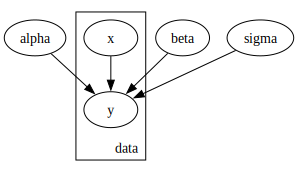

In [2]:
def linear_model_bayesian_direct(X=None, Y=None):
    # Priors for slope and intercept
    slope = pyro.sample('alpha', dist.Normal(0, 10))
    intercept = pyro.sample('beta', dist.Normal(0, 10))
    sigma = pyro.sample('sigma', dist.Uniform(1, 2))

    # Linear model
    n = len(X) if X is not None else 1
    # Likelihood
    with pyro.plate('data', n, dim=-1):
        x = pyro.sample('x', dist.Uniform(-1,1), obs=X)
        mean = slope * x + intercept
        y = pyro.sample('y', dist.Normal(mean, sigma), obs=Y)

    return y

pyro.render_model(linear_model_bayesian_direct)

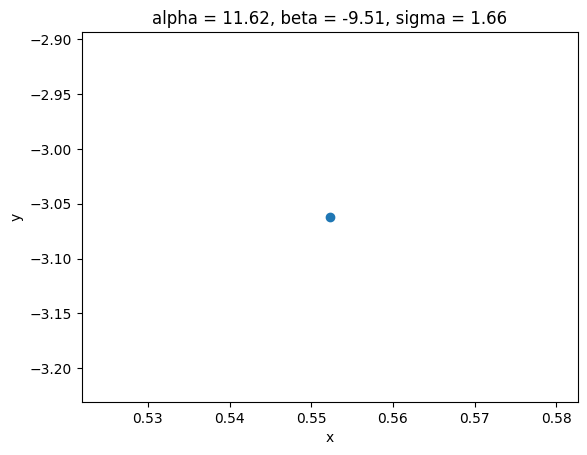

(tensor([0.5523]), tensor([-3.0620]))

In [3]:
def draw_and_plot_samples(model, **kwargs):
    from pyro.poutine import trace

    tr = trace(model).get_trace(**kwargs)
    x, y = tr.nodes['x']['value'], tr.nodes['y']['value']
    alpha, beta, sigma = tr.nodes['alpha']['value'], tr.nodes['beta']['value'], tr.nodes['sigma']['value']

    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    # format to 2 decimal points
    plt.title(f'alpha = {alpha:.2f}, beta = {beta:.2f}, sigma = {sigma:.2f}')
    plt.show()

    return x,y

draw_and_plot_samples(linear_model_bayesian_direct)

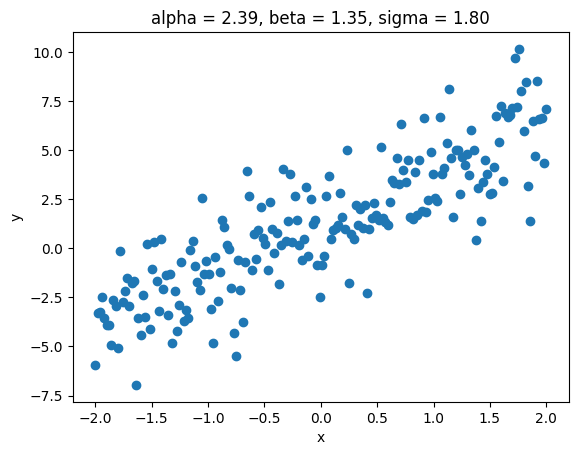

(tensor([-2.0000, -1.9799, -1.9598, -1.9397, -1.9196, -1.8995, -1.8794, -1.8593,
         -1.8392, -1.8191, -1.7990, -1.7789, -1.7588, -1.7387, -1.7186, -1.6985,
         -1.6784, -1.6583, -1.6382, -1.6181, -1.5980, -1.5779, -1.5578, -1.5377,
         -1.5176, -1.4975, -1.4774, -1.4573, -1.4372, -1.4171, -1.3970, -1.3769,
         -1.3568, -1.3367, -1.3166, -1.2965, -1.2764, -1.2563, -1.2362, -1.2161,
         -1.1960, -1.1759, -1.1558, -1.1357, -1.1156, -1.0955, -1.0754, -1.0553,
         -1.0352, -1.0151, -0.9950, -0.9749, -0.9548, -0.9347, -0.9146, -0.8945,
         -0.8744, -0.8543, -0.8342, -0.8141, -0.7940, -0.7739, -0.7538, -0.7337,
         -0.7136, -0.6935, -0.6734, -0.6533, -0.6332, -0.6131, -0.5930, -0.5729,
         -0.5528, -0.5327, -0.5126, -0.4925, -0.4724, -0.4523, -0.4322, -0.4121,
         -0.3920, -0.3719, -0.3518, -0.3317, -0.3116, -0.2915, -0.2714, -0.2513,
         -0.2312, -0.2111, -0.1910, -0.1709, -0.1508, -0.1307, -0.1106, -0.0905,
         -0.0704, -0.0503, -

In [4]:
# sample from the model
# generate random x between 0 and 1
n = 200
x = torch.linspace(-2,2,n)
draw_and_plot_samples(linear_model_bayesian_direct,X=x)


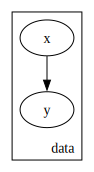

In [5]:
class LinearModel(PyroModule):
    def __init__(self, n):
        super().__init__()
        self.n = n
    
    def forward(self, slope,intercept,sigma, x=None, y=None):
        with pyro.plate('data', self.n, dim=-1):
            x = pyro.sample('x', dist.Uniform(-1,1), obs=x)
            mean = slope * x + intercept
            y = pyro.sample('y', dist.Normal(mean, sigma), obs=y)
        return x,y
    
n = 200
linear_model = LinearModel(n)

pyro.render_model(linear_model,(-0.5, 1.1, 0.01))


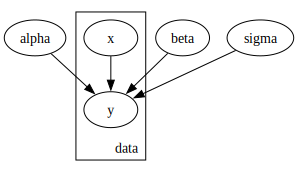

In [44]:
class BayesianLinearModel(PyroModule):
    def __init__(self, n):
        super().__init__()

        self.n = n
        self.linear_model = LinearModel(self.n)
    
    def forward(self, x=None, y=None):
        alpha = pyro.sample('alpha',dist.Normal(0,100))
        beta = pyro.sample('beta',dist.Uniform(-2, 2))
        sigma = pyro.sample('sigma',dist.Uniform(0,2))
        return self.linear_model(beta,alpha,sigma,x, y)

# sample from the model and plot the pairs (x,y)
n = 200
bayesian_model = BayesianLinearModel(n)

pyro.render_model(bayesian_model)



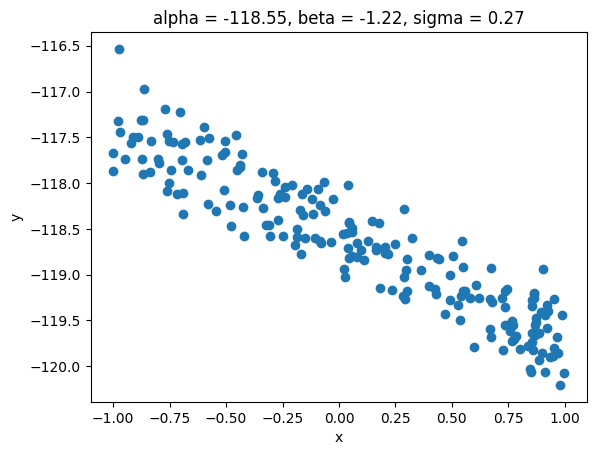

(tensor([ 0.7709,  0.2948,  0.3247, -0.7511, -0.8902, -0.2393, -0.6167,  0.2837,
          0.2150,  0.1285,  0.0194,  0.9189,  0.1476, -0.5041,  0.3011,  0.7739,
          0.7357,  0.2888, -0.3092,  0.5976, -0.1205, -0.3071, -0.1872, -0.9217,
         -0.5780,  0.8544, -0.2393, -0.5767,  0.0453, -0.0822,  0.8844,  0.9692,
         -0.1063, -0.3383, -0.7451,  0.9106, -0.8324,  0.7283,  0.8959, -0.4192,
          0.5436,  0.4355, -0.7979,  0.3615,  0.7639,  0.9501,  0.9968,  0.3970,
         -0.6915, -0.7685,  0.4302,  0.8610, -0.2593,  0.0567,  0.8632, -0.9997,
          0.8697, -0.9140,  0.4446, -0.6972,  0.4905, -0.1932,  0.8864, -0.2701,
         -0.5958, -0.5843, -0.7185,  0.6673, -0.1576, -0.1635,  0.0461, -0.4398,
          0.9117, -0.2822,  0.6073,  0.5578, -0.7597,  0.5412, -0.9465,  0.9049,
         -0.1851, -0.4574, -0.4798,  0.7628,  0.1125,  0.1832,  0.7438, -0.1143,
          0.8026, -0.4839,  0.1633,  0.7367,  0.9364, -0.0666,  0.2928, -0.6680,
          0.8371,  0.0977,  

In [45]:
draw_and_plot_samples(bayesian_model)

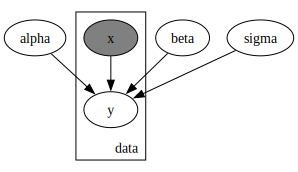

In [13]:
from chirho.observational.handlers import condition

class ConditionedLinearModel(PyroModule):
    def __init__(self, n: int):
        super().__init__()
        self.n = n
        self.causal_linear_model = BayesianLinearModel(self.n)

    def forward(self, x=None, y=None):
        with condition(data={'x': x, 'y': y}):
            return self.causal_linear_model(x,y)

x = torch.linspace(-2,2,n)   
conditioned_model = ConditionedLinearModel(n)

pyro.render_model(conditioned_model, (x,))

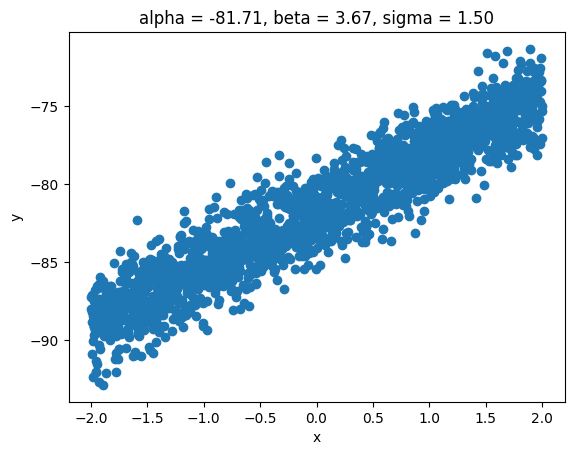

In [14]:
x,y = draw_and_plot_samples(conditioned_model, x=x)

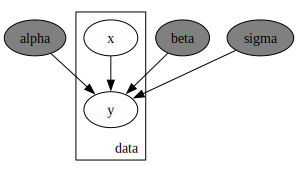

In [46]:
alpha, beta, sigma = torch.tensor(20), torch.tensor(-1.5), torch.tensor(0.01)
true_generative_model = pyro.condition(bayesian_model, data={'alpha': alpha, 'beta': beta, 'sigma': sigma})
pyro.render_model(true_generative_model)



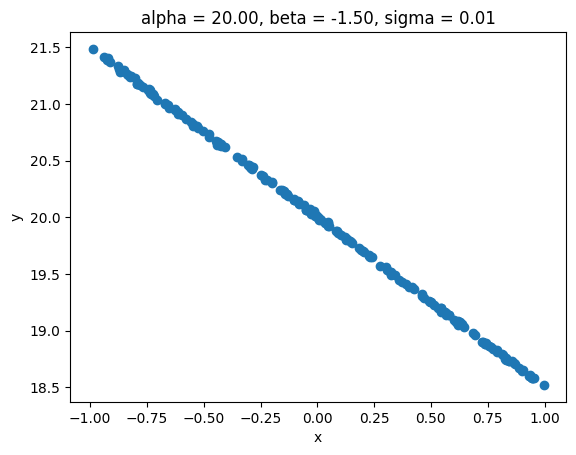

In [47]:
x,y=draw_and_plot_samples(true_generative_model)

### Toy exercise - identifying the casual effect of $X\to Y$ with ChiRho

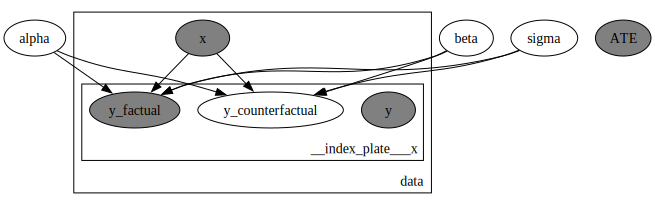

In [48]:
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do

class LinearATE(PyroModule):
    def __init__(self, n : int):
        super().__init__()
        self.n = n
        self.observational_model = ConditionedLinearModel(self.n)

    def forward(self, x_obs, y_obs):
        with MultiWorldCounterfactual(), do(actions=dict(x=(-0.5,0.5))):
            _, y_all = self.observational_model(x=x_obs, y=y_obs)
            y_cf_1 = gather(y_all, IndexSet(x={2}))
            y_cf_0 = gather(y_all, IndexSet(x={1}))
        
        ate =  (y_cf_1 - y_cf_0).mean()
        return pyro.deterministic("ATE", ate, event_dim=0)
        
ate_model = LinearATE(len(x))
pyro.render_model(ate_model, (x,y))


In [35]:
ate_model(x,y)

tensor(-0.8149)

#### Causal inference is probabilistic inference

In [49]:
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO

num_iterations = 5000 if not smoke_test else 10

pyro.clear_param_store()

adam = pyro.optim.Adam({"lr": 0.03})

ate_guide = AutoNormal(ate_model)

svi = SVI(ate_model, ate_guide, adam, loss=Trace_ELBO())

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x,y)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))

/Users/dima/git/chirho/.conda/lib/python3.11/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'__index_plate___x'}
  warnings.warn(


[iteration 0001] loss: 45563.4687
[iteration 1001] loss: 441.6101
[iteration 2001] loss: -377.8676
[iteration 3001] loss: -496.0686
[iteration 4001] loss: -564.5732


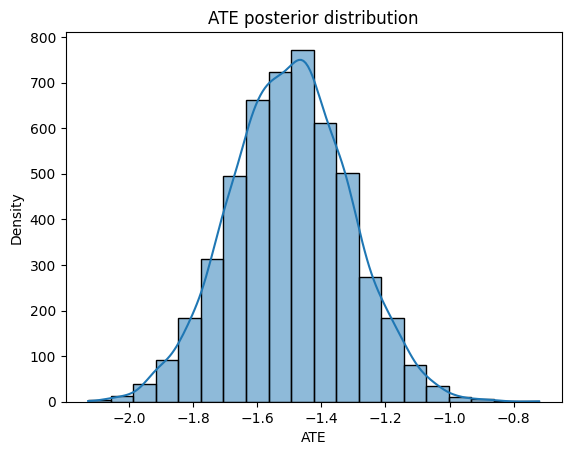

In [50]:
from pyro.infer import Predictive

# Create Predictive object
predictive = Predictive(ate_model, guide=ate_guide, num_samples=5000)

# Make predictions
predictions = predictive(x,y)

# Extract predictions
predicted_ates = predictions["ATE"].squeeze()

# plot histogram
sns.histplot(predicted_ates, bins=20, kde=True)
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title('ATE posterior distribution')
plt.show()

## Add an observed covariate